# Preparations

<b>Load Libraries</b>

In [1]:
# udf 
import os, sys
cwd = os.getcwd()
os.chdir('../')
path_to_src = os.getcwd()
if path_to_src not in sys.path:
    sys.path.append(path_to_src)
os.chdir(cwd)
##
from src.notebook.support import *

# others 
from warnings import simplefilter

<b>Load Dataset</b>

In [2]:
# materials
materials = prepare_data_to_train(path='../cache/data/cleaned.csv')

<b>MLflow</b>

In [3]:
# local server
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
experiment_name = 'Feature engineering'
try:
    mlflow.create_experiment(name=experiment_name, artifact_location='cache/mlflow/')
except:
    mlflow.set_experiment(experiment_name=experiment_name)

# 1. Baseline Evaluation

In [25]:
# dtype's indexs separation
num_iters = materials['X_train'].shape[1]
num_idxes, cat_idxes = [], []
for i in range(num_iters):
    try:
        float(materials['X_train'][0, i])
        num_idxes.append(i)
    except:
        cat_idxes.append(i)

In [27]:
# warnings
simplefilter(action='ignore')

# base models
base_models = load_base_models()

# trasnformers
ct = ColumnTransformer([('num', SimpleImputer(strategy='mean'), num_idxes), 
                        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)])

# pipeline
pipelines = []
for name, model in base_models:
    pipeline = Pipeline([('trans', ct), 
                         (name, model)])
    pipelines.append((name, pipeline))

kfold_results = get_kfold_results(pipelines, materials['X_train'], materials['y_train'])

LR: 0.5548661113299678 (0.04369139815455173)
KNN: 0.4548394723104091 (0.03433325221650186)
SVM: 0.0 (0.0)
CART: 0.4957749959043213 (0.04017658776461393)
ET: 0.4762630518355428 (0.04303123938382178)
RF: 0.5043925188651162 (0.03944302455773444)
GB: 0.5274743896158584 (0.043488587685004416)
LGBM: 0.5382867199463449 (0.036403060684741764)
XGB: 0.5193133799161977 (0.039198658078844165)


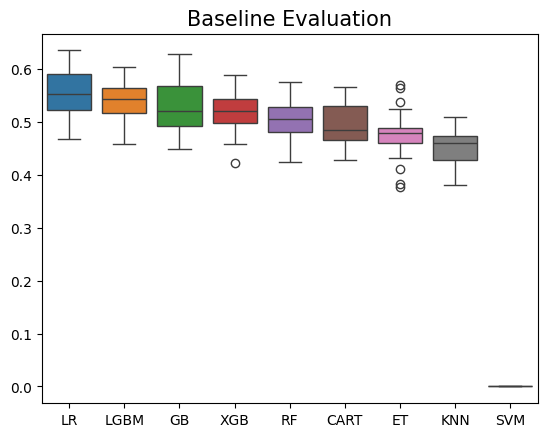

In [28]:
# plot kfold results
plot_kfold_results(kfold_results, 'Baseline Evaluation')

In [31]:
# mlflow
for name, pipeline in pipelines:
    ##
    pipeline.fit(materials['X_train'], materials['y_train'])
    val_predictions = pipeline.predict(materials['X_test'])
    val_fbeta = fbeta_score(y_true=materials['y_test'], y_pred=val_predictions, 
                            beta=2)
    ##
    with mlflow.start_run():
        ### tags
        mlflow.set_tags({'pre_pro': 'si(mean)_ohe', 
                         'base_model': name, 
                         'beta_f': 2})
        ###
        mlflow.log_metrics({'avg_fbeta': kfold_results[name].mean(), 
                            'val_fbeta': val_fbeta})
        ###
        mlflow.sklearn.log_model(artifact_path='model', 
                                 sk_model=pipeline)

In [4]:
# infer pip requirements
runs_id = mlflow.search_runs(
    filter_string="tags.base_model = 'LR' and tags.pre_pro = 'si(mean)_ohe'"
)['run_id'].values[0]
pip_requirements = infer_pip_requirements(
    model_uri=f'runs:/{runs_id}/model', 
    flavor='sklearn'
)
pip_requirements.extend(['mlxtend==0.23.1', 'pickle==4.0'])
pip_requirements

['cloudpickle==3.0.0',
 'imbalanced-learn==0.12.3',
 'numpy==1.26.4',
 'psutil==6.0.0',
 'scikit-learn==1.5.1',
 'scipy==1.14.0',
 'mlxtend==0.23.1',
 'pickle==4.0']

In [5]:
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask].tolist(), idxes[mask].tolist()

    return passed, failed

std = Node('std', StandardScaler())
std.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), StandardScaler()))
impute.test = lambda data: (data['idxes'], [])
std.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe = lambda data: (data['idxes'], [])

left = [std, impute]
right = [ohe]

tree = InitBinaryTree(left, right)

In [12]:
simplefilter(action='ignore')

base_model = get_seleted_models(['LR'])

transformers = SFS(tree)

pipeline = Pipeline([('trans', transformers)] + base_model)

sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2),
    verbose=2
)
sfs.fit(materials['X_train'], materials['y_train'])

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/imblearn/pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/imblearn/pipeline.py", line 255, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/imblearn/pipeline.py", line 1104, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xxo/miniconda3/envs/mlops/lib/python3.11/site-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xxo/working/src/notebook/support.py", line 247, in fit
    self.tree.right[0].data.update({'X': X, 'idxes': idxes['cat']})
    ^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'function' object has no attribute 'data'
